In [150]:
# Authentication to Google API
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='image-proceesing -project414814-e39e3deaf68d.json'
import cv2
from google.cloud import vision

# re is used to extract IMEI using regex
import re
from google.cloud import vision
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageDraw, ImageFont
import fitz  # PyMuPDF
from PIL import Image
import io
from tqdm import tqdm

In [151]:
def extract_text_with_coordinates(pdf_path, output_json_file):
    """
    Extract text with word coordinates from a local PDF file using Google Cloud Vision API.

    Args:
        pdf_path (str): Path to the local PDF file.
        output_json_file (str): Path to save the extracted text and coordinates as a JSON file.

    Returns:
        None
    """
    client = vision.ImageAnnotatorClient()

    # Open the PDF and process each page
    pdf_document = fitz.open(pdf_path)
    text_data = {
        "pages": []
    }

    for page_num in range(len(pdf_document)):
        print(f"Processing page {page_num + 1}...")
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap(dpi=300)
        img_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)

        # Convert the image to bytes
        _, img_bytes = cv2.imencode('.jpg', img_array)
        image = vision.Image(content=img_bytes.tobytes())

        # Call the Vision API
        response = client.document_text_detection(image=image)

        if response.error.message:
            raise Exception(f"Google Vision API error: {response.error.message}")

        annotation = response.full_text_annotation

        # Initialize page-specific data
        page_data = {
            "text": annotation.text,  # Store page-specific text here
            "width": annotation.pages[0].width,
            "height": annotation.pages[0].height,
            "blocks": []
        }

        for block in annotation.pages[0].blocks:
            block_data = {
                "bounding_box": [(vertex.x, vertex.y) for vertex in block.bounding_box.vertices],
                "paragraphs": []
            }

            for paragraph in block.paragraphs:
                paragraph_data = {
                    "bounding_box": [(vertex.x, vertex.y) for vertex in paragraph.bounding_box.vertices],
                    "words": []
                }

                for word in paragraph.words:
                    word_data = {
                        "text": ''.join([symbol.text for symbol in word.symbols]),
                        "bounding_box": [(vertex.x, vertex.y) for vertex in word.bounding_box.vertices]
                    }
                    paragraph_data["words"].append(word_data)

                block_data["paragraphs"].append(paragraph_data)

            page_data["blocks"].append(block_data)

        text_data["pages"].append(page_data)

    pdf_document.close()

    # Save the extracted data to a JSON file
    with open(output_json_file, "w", encoding="utf-8") as f:
        json.dump(text_data, f, indent=4, ensure_ascii=False)

    print(f"Text and coordinates saved to {output_json_file}")


In [152]:
pdf_path = "arabic.pdf"
output_json_file = "arabic.json"
extract_text_with_coordinates(pdf_path, output_json_file)

Processing page 1...
Text and coordinates saved to arabic.json


In [153]:
def convert_pdf_to_images_fitz(pdf_path, target_width=1300, target_height=1700):
    """
    Convert a PDF file to a list of images with their original dimensions.

    Args:
        pdf_path (str): Path to the PDF file to convert.
        target_width (int): Target width for scaling the images.
        target_height (int): Target height for scaling the images.

    Returns:
        tuple: Two lists - one with PIL.Image objects and one with original sizes.
    """
    doc = fitz.open(pdf_path)
    images = []
    original_sizes = []

    for page in tqdm(doc, desc="Converting pages to images"):
        # Original dimensions of the page
        rect = page.rect
        original_width, original_height = rect.width, rect.height
        original_sizes.append((original_width, original_height))

        # Calculate scale factors to match the target size
        scale_x = target_width / original_width
        scale_y = target_height / original_height

        # Get the pixmap with scaling to target size
        matrix = fitz.Matrix(scale_x, scale_y)
        pix = page.get_pixmap(matrix=matrix)

        # Convert the pixmap to a PIL Image
        img = Image.open(io.BytesIO(pix.tobytes("ppm")))

        # Ensure the image matches the target size (in case of rounding differences)
        img = img.resize((target_width, target_height), Image.LANCZOS)

        # Append to the list of images
        images.append(img)

    return images, original_sizes

In [154]:
images,original_sizes = convert_pdf_to_images_fitz(pdf_path)

Converting pages to images: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]


In [155]:
len(images),len(original_sizes)

(1, 1)

In [156]:
original_sizes[0]

(595.3200073242188, 841.9200439453125)

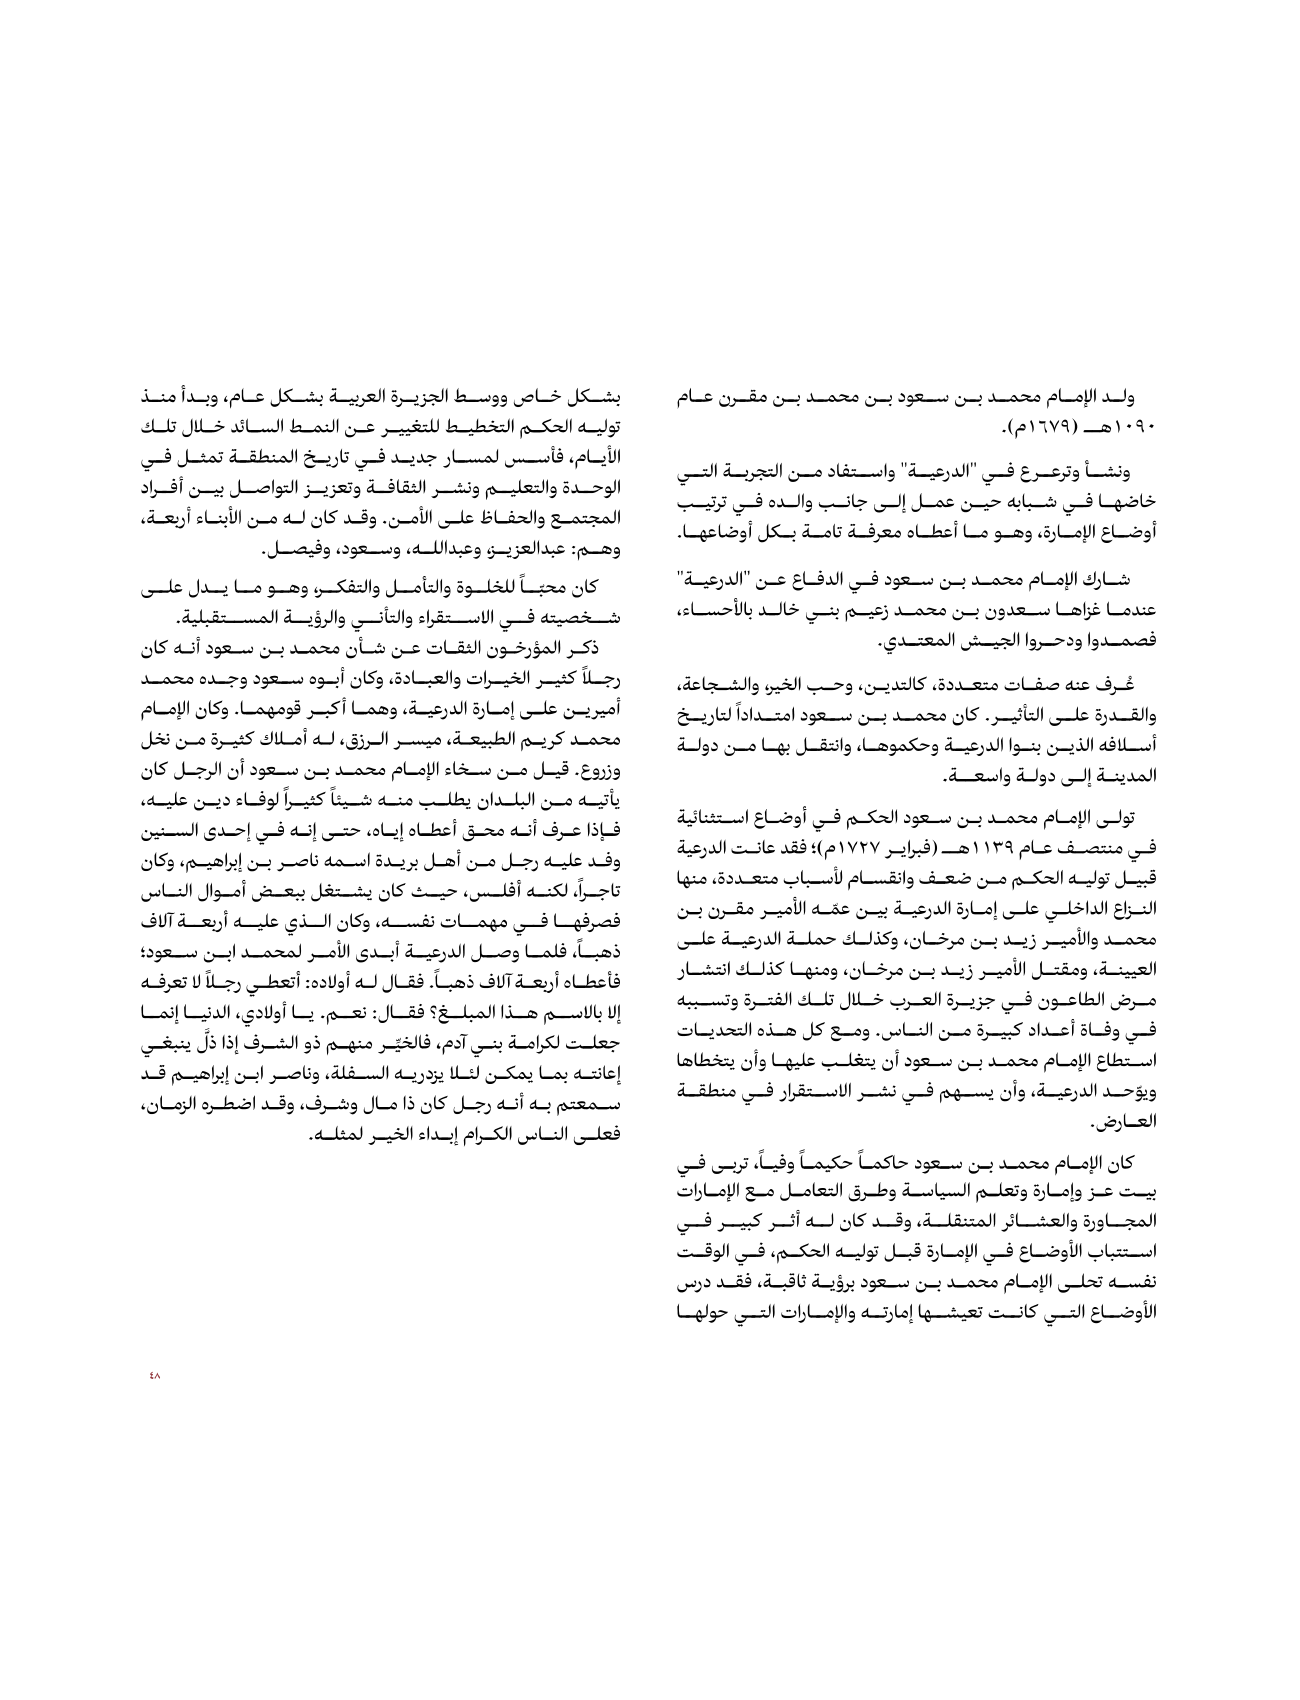

In [157]:
display(images[0])

In [158]:
width,height = images[0].size
width,height

(1300, 1700)

In [159]:
with open('arabic.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [160]:
type(data)

dict

In [161]:
data.keys()

dict_keys(['pages'])

In [162]:
data['pages'][0]["text"]

'ولد الإمام محمد بن سعود بن محمد بن مقرن عام بشكل خاص ووسط الجزيرة العربية بشكل عام، وبدأ منذ\n١٠٩۰هـ (١٦٧٩م).\nونشأ وترعرع في "الدرعية" واستفاد من التجربة التي\nخاضها في شبابه حين عمل إلى جانب والده في ترتيب\nأوضاع الإمارة، وهو ما أعطاه معرفة تامة بكل أوضاعها.\nتوليه الحكم التخطيط للتغيير عن النمط السائد خلال تلك\nالأيام، فأسس لمسار جديد في تاريخ المنطقة تمثل في\nالوحدة والتعليم ونشر الثقافة وتعزيز التواصل بين أفراد\nالمجتمع والحفاظ على الأمن. وقد كان له من الأبناء أربعة\nوهم عبد العزيز وعبدالله، وسعود، وفيصل.\nذكر المؤرخون الثقات عن شأن محمد بن سعود أنه كان\nشارك الإمام محمد بن سعود في الدفاع عن "الدرعية" كان محباً للخلوة والتأمل والتفكر، وهو ما يدل على\nعندما غزاها سعدون بن محمد زعيم بني خالد بالأحساء، شخصيته في الاستقراء والتأني والرؤية المستقبلية.\nفصمدوا ودحروا الجيش المعتدي.\nغرف عنه صفات متعددة كالتدين، وحب الخير والشجاعة رجلاً كثير الخيرات والعبادة، وكان أبوه سعود وجده محمد\nوالقدرة على التأثير. كان محمد بن سعود امتداداً لتاريخ أميرين على إمارة الدرعية، وهما أكبر قومهما. وكان 

In [16]:
# data['pages'][0]

In [75]:
def normalize_boxes(boxes, page_width, page_height, image_width, image_height):
    """
    Normalize bounding boxes from page coordinates to image coordinates.

    Args:
        boxes (list): A list of bounding boxes in page coordinates.
        page_width (int): Width of the page.
        page_height (int): Height of the page.
        image_width (int): Width of the image.
        image_height (int): Height of the image.

    Returns:
        list: Normalized bounding boxes in image coordinates.
    """
    normalized_boxes = []
    for box in boxes:
        normalized_box = [
            (
                int((x / page_width) * image_width),
                int((y / page_height) * image_height)
            )
            for x, y in box
        ]
        normalized_boxes.append(normalized_box)
    return normalized_boxes



def process_page_and_draw_boxes(page_data, image):
    """
    Process page data to extract bounding boxes, normalize them, and draw them on the image.

    Args:
        page_data (dict): The page data containing word bounding boxes.
        image (PIL.Image): The image to draw on.

    Returns:
        None
    """
    page_width = page_data.get("width", 1)
    page_height = page_data.get("height", 1)
    image_width, image_height = image.size

    boxes = []

    # Extract bounding boxes from page data
    for block in page_data.get("blocks", []):
        for paragraph in block.get("paragraphs", []):
            for word in paragraph.get("words", []):
                bounding_box = word.get("bounding_box", [])
                if bounding_box:
                    boxes.append([(x, y) for x, y in bounding_box])

    # Normalize the bounding boxes
    normalized_boxes = normalize_boxes(boxes, page_width, page_height, image_width, image_height)
    return normalized_boxes



In [163]:
def draw_boxes(image, boxes):
    """
    Draw bounding boxes around words on an image.

    Args:
        image (PIL.Image): The image to draw on.
        boxes (list): A list of bounding boxes, where each box is a list of (x, y) tuples.

    Returns:
        None
    """
    modified_image = image.copy()
    draw = ImageDraw.Draw(modified_image)

    # Loop through the bounding boxes and draw them
    for box in boxes:
        try:
            draw.polygon(box, outline="red", width=2)
        except Exception as e:
            print(f"Error drawing box: {e}")
            continue

    # Display the image with bounding boxes
    display(modified_image)

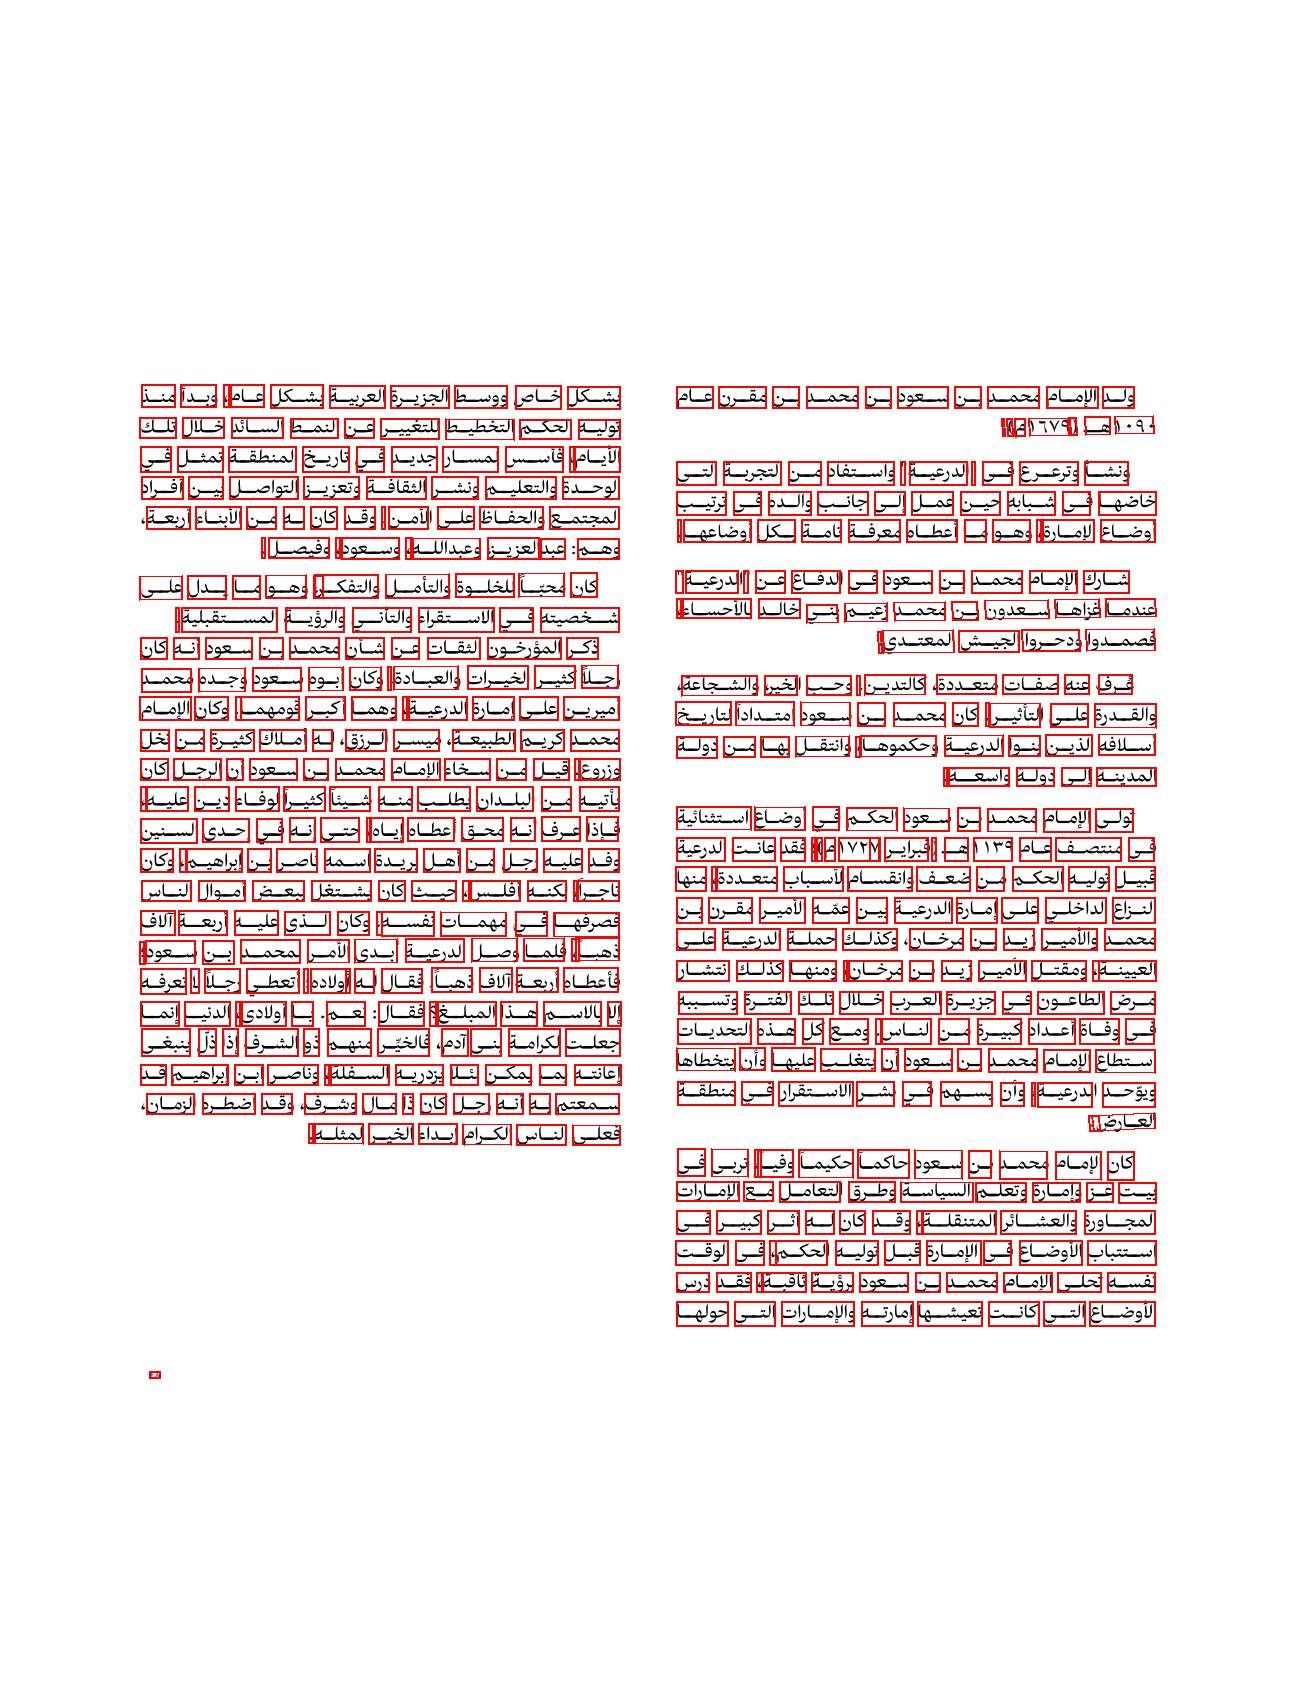

In [164]:
normalized_boxes=process_page_and_draw_boxes(data['pages'][0], images[0])
    # Draw the normalized bounding boxes on the image
draw_boxes(images[0], normalized_boxes)

In [165]:
normalized_boxes[0]

[(1102, 386), (1134, 386), (1134, 408), (1102, 408)]

In [166]:
data.keys()

dict_keys(['pages'])

In [167]:
def normalize_boxes(boxes, page_width, page_height, image_width, image_height):
    """
    Normalize bounding boxes from page coordinates to image coordinates.

    Args:
        boxes (list): A list of bounding boxes in page coordinates (list of [x, y] pairs).
        page_width (int): Width of the page.
        page_height (int): Height of the page.
        image_width (int): Width of the image.
        image_height (int): Height of the image.

    Returns:
        list: Normalized bounding boxes in image coordinates.
    """
    normalized_boxes = []
    for box in boxes:
        normalized_box = [
            (
                int((x / page_width) * image_width),
                int((y / page_height) * image_height)
            )
            for x, y in box
        ]
        normalized_boxes.append(normalized_box)
    return normalized_boxes

def normalize_words_with_coordinates(data, page_width, page_height, image_width, image_height,page_num):
    """
    Extract words and normalize their bounding boxes.

    Args:
        data (dict): The input data structure containing page information.
        page_width (int): Width of the page.
        page_height (int): Height of the page.
        image_width (int): Width of the image.
        image_height (int): Height of the image.

    Returns:
        list: A list of words with their normalized bounding boxes.
    """
    words_with_coordinates = []

    for block in data['pages'][page_num]['blocks']:
        for paragraph in block['paragraphs']:
            for word in paragraph['words']:
                try:
                    normalized_box = normalize_boxes(
                        [word['bounding_box']],  # Ensure it's a list of bounding boxes
                        page_width, page_height, image_width, image_height
                    )
                    words_with_coordinates.append({
                        word['text']: normalized_box[0]  # Unpack the single normalized box
                    })
                except Exception as e:
                    print(f"Error normalizing word '{word['text']}': {e}")
                    continue

    return words_with_coordinates


In [168]:
page_width = data['pages'][0].get("width", 1)
page_height = data['pages'][0].get("height", 1)
image_width, image_height = images[0].size

words_with_coordinates=normalize_words_with_coordinates(data, page_width, page_height, image_width, image_height,page_num=0)

In [169]:
words_with_coordinates[0]

{'ولد': [(1102, 386), (1134, 386), (1134, 408), (1102, 408)]}

In [147]:
# Helper function for creating a blank image
def create_blank_image(width, height):
    return Image.new("RGB", (width, height), "white")

def calculate_rectangle_height(coordinates):
    # Calculate the vertical span (height) of the rectangle
    xs = [coord[0] for coord in coordinates]
    ys = [coord[1] for coord in coordinates]

    width = max(xs) - min(xs)
    height = max(ys) - min(ys)

    return width, height
def assign_font_weight(width,height,font_path):
    direction = "vertical" if height > 1.5 * width else "horizontal"
    if direction =="horizontal":
        if height > 35:
            return ImageFont.truetype(40)  # Set font size to 40 if height is more than 35
        else:
            size_per_unit_height = 1  # Size increase per pixel of height
            calculated_size = int(height* size_per_unit_height)
    else:
        size_per_unit_width = 1  # Size increase per pixel of height
        calculated_size = int(width* size_per_unit_width)
        
    return ImageFont.truetype(font_path, calculated_size)  

        
def draw_words(image, boxes):
    """
    Draw words on an image with consideration for vertical text formatting.

    Args:
        image (PIL.Image): The image to draw on.
        boxes (list): A list of dictionaries where each contains a word and its bounding box coordinates.

    Returns:
        PIL.Image: The modified image with words drawn on it.
    """
    modified_image = image
    draw = ImageDraw.Draw(modified_image)

    for box_info in boxes:
        word, box_coords = list(box_info.items())[0]
        try:
            # Calculate center, width, and height of the bounding box
            center_x = (box_coords[0][0] + box_coords[2][0]) / 2
            center_y = (box_coords[0][1] + box_coords[2][1]) / 2
            width, height = calculate_rectangle_height(box_coords)
            
            # Assign appropriate font
            font = assign_font_weight(width, height, "Arial.ttf")

            # Check if the text is likely vertical
            is_vertical = height > 1.5 * width

            if is_vertical:
                # Render vertical text
                for i, char in enumerate(word):
                    char_x = center_x - width / 2
                    char_y = center_y - height / 2 + i * (height / len(word))
                    draw.text((char_x, char_y), char, fill="black", font=font)
            else:
                # Render horizontal text
                text_bbox = draw.textbbox((center_x, center_y), word, font=font)
                text_width = text_bbox[2] - text_bbox[0]
                text_height = text_bbox[3] - text_bbox[1]

                # Center text within the box
                text_x = center_x - text_width / 2
                text_y = center_y - text_height / 2

                draw.text((text_x, text_y), word, fill="black", font=font)
        except Exception as e:
            print(f"Error drawing box for word '{word}': {e}")

    return modified_image

In [170]:
width,height = images[0].size
blank_image=create_blank_image(width, height)

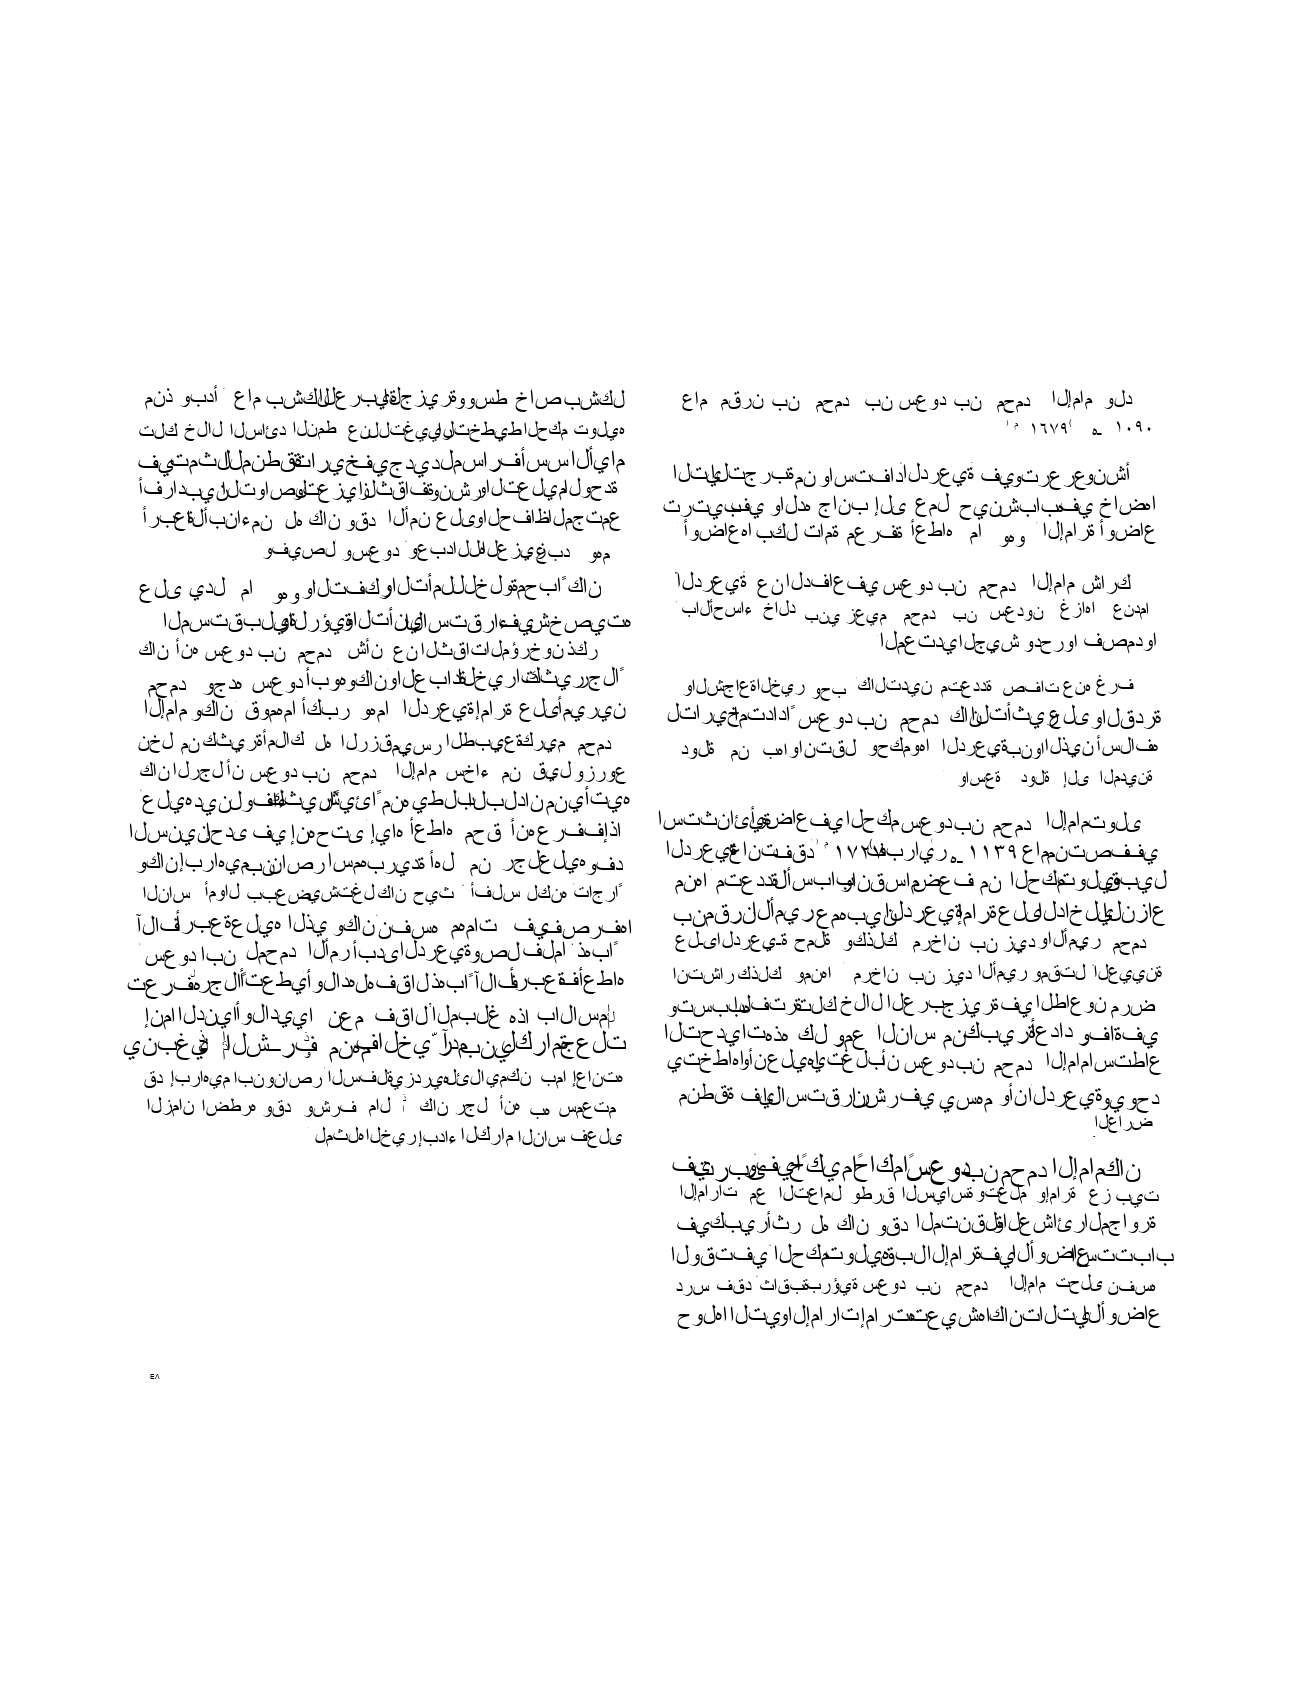

In [171]:
draw_words(blank_image, words_with_coordinates)

In [124]:
imge2=draw_words(blank_image, words_with_coordinates)

In [125]:
# to numpy array
image = np.array(imge2)
# Invert/negate the image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

inverted_image = cv2.bitwise_not(gray_image)

mean_projection = np.mean(inverted_image, axis=0)

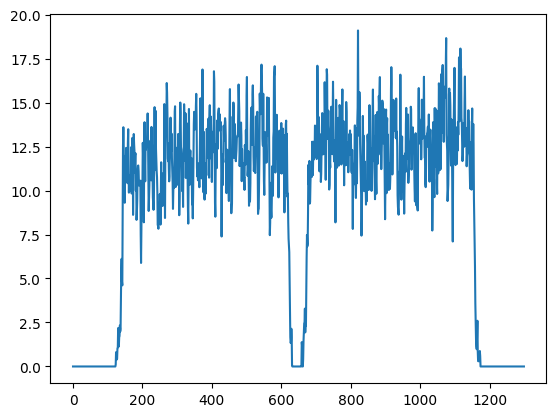

In [126]:
plt.plot(mean_projection)
plt.show()

In [172]:
def count_continuous_sequences_above_average(numbers):
    y_tolerance = 0.5
    sequences = []
    current_sequence = []
    split_indices = []
    for i, num in enumerate(numbers):
        if num > y_tolerance:
            current_sequence.append(num)
        else:
            if current_sequence and sum(current_sequence) > 200:
                sequences.append(current_sequence)
                split_indices.append(i)
            current_sequence = []
    # Handle the last sequence if not ended with zero
    if current_sequence and sum(current_sequence) > 200:
        sequences.append(current_sequence)
        split_indices.append(len(numbers))
    if not sequences:
         return None,0
    count_above_average = sum(1 for seq in sequences if sum(seq) > 200)
    split_points = []
    for index in split_indices:
        if index > 0:
            # Find the middle point between the two continuous sequences
            split_point = (index + index + 1) // 2
            split_points.append(split_point)
    return split_points,count_above_average

In [173]:
split_point,columns_num=count_continuous_sequences_above_average(mean_projection)

In [174]:
columns_num

2

In [129]:
height

1700

In [176]:
def draw_boxes2(image, vertical_points):
    modified_image = image.copy()
    draw = ImageDraw.Draw(modified_image)
#     # Loop through the bounding boxes and draw them
#     for box in boxes:
#         try:
#             draw.polygon(box, outline="red", width=2)
#         except:
#             continue
    
    # Draw vertical lines at specified horizontal points with y=20 to y=300
    for x in vertical_points:
        draw.line([(x, 20), (x, height)], fill="red", width=5)

    # Display the image with bounding boxes and vertical lines
    # Display the image with bounding boxes
    display(modified_image)

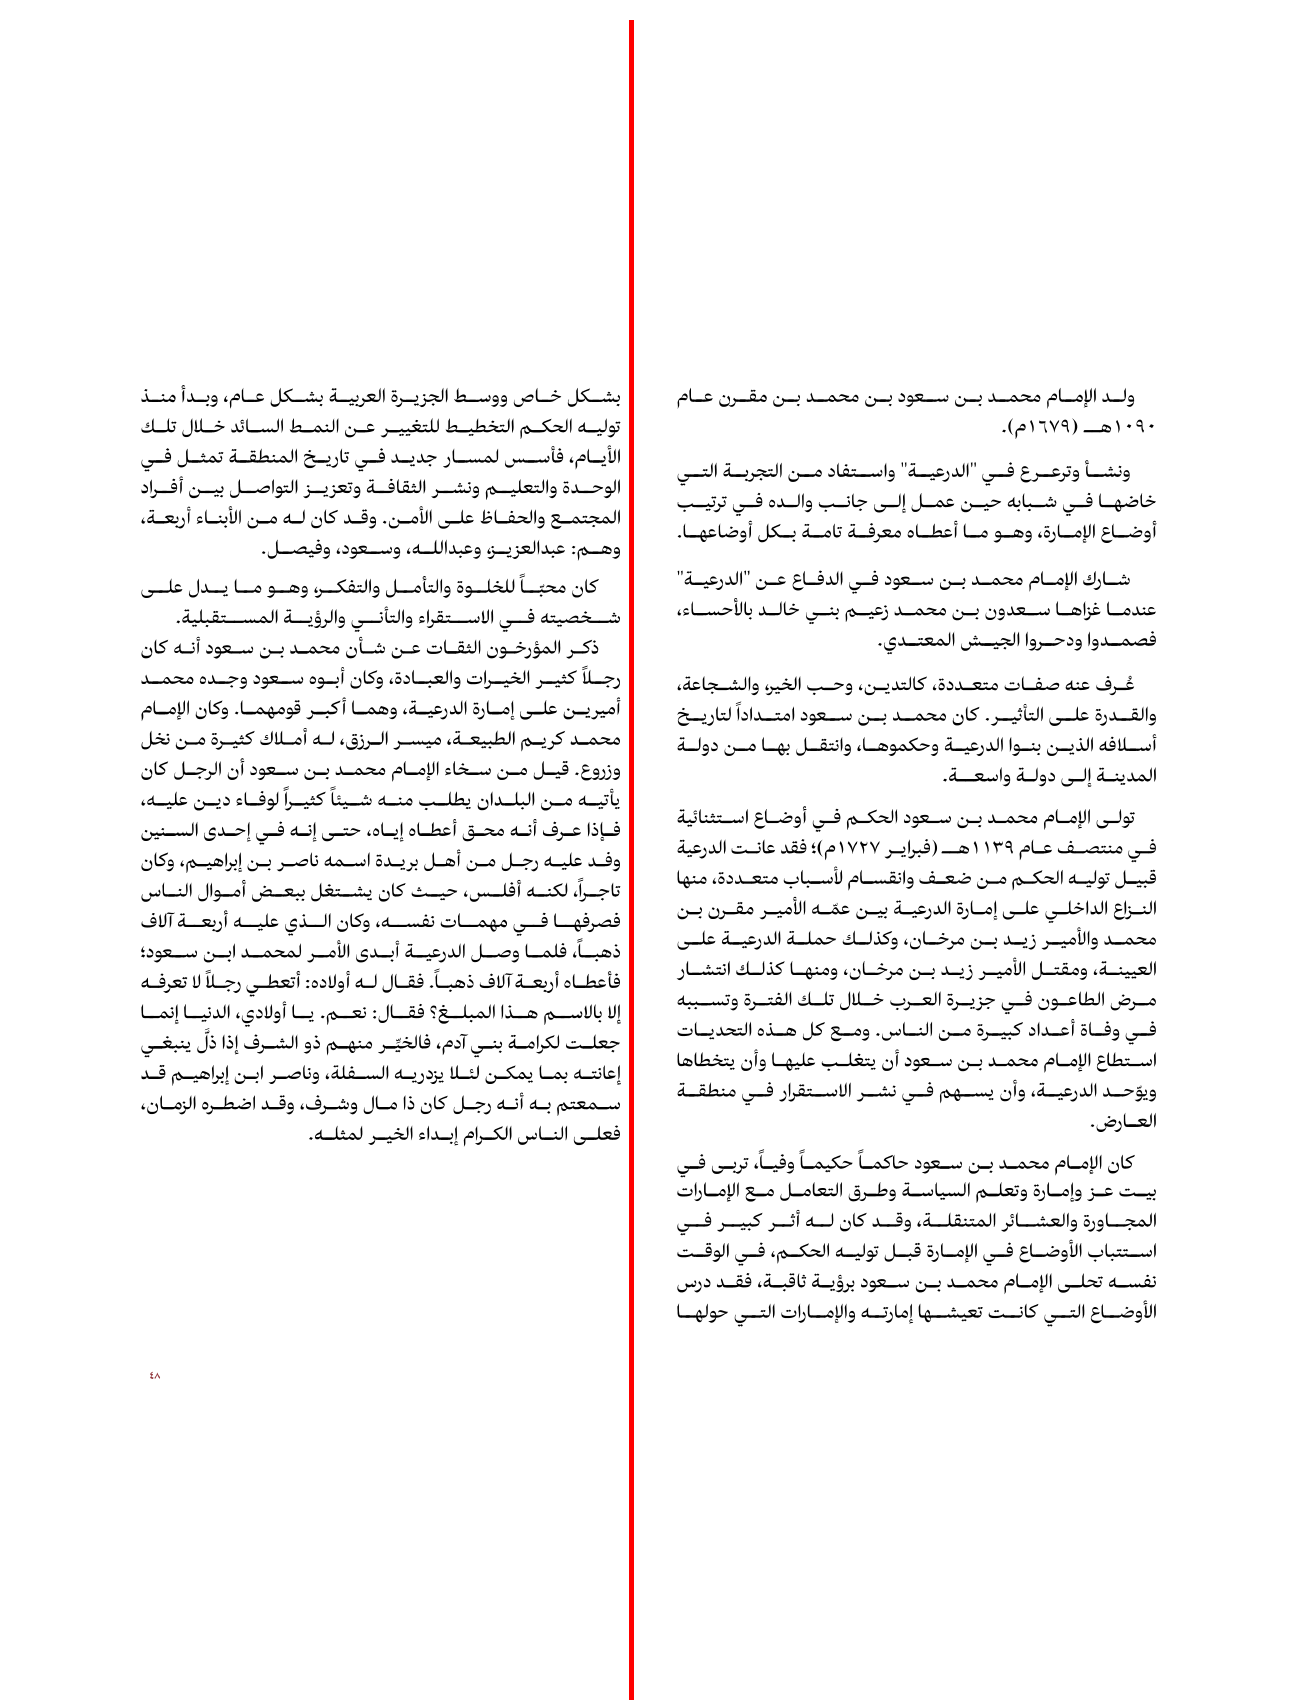

In [177]:
draw_boxes2(images[0], vertical_points=split_point[:-1])

In [178]:
def separate_words(sep_points,words_corr):
    if sep_points!=None:
        sep_points = sorted(sep_points)  # Ensure separation points are in ascending order
        columns = [[] for _ in range(len(sep_points))]  # Initialize columns list for each line and the areas outside the lines
        for word_dict in words_corr:
            for word, coords in word_dict.items():
                word_center = ((coords[0][0] + coords[2][0]) / 2, (coords[0][1] + coords[2][1]) / 2)
                for i, point in enumerate(sep_points):
                    if word_center[0] < point+25:  # Word is on the left side of the current separation point
                        columns[i].append(word_dict)
                        break
                else:  # Word is on the right side of the last separation point or outside all separation points
                    columns[-1].append(word_dict)
        return columns
    else:
        list_of_dicts=separate_words_nocloumns(words_corr)
        return [list_of_dicts]

In [179]:
columns=separate_words(split_point,words_with_coordinates)

In [180]:
words_lists=columns

In [181]:
len(words_lists)

2

In [182]:
def text_clean(content):
    # Remove new lines
    content = ' '.join(content.split('\n'))
    # Remove all English words (including URLs and credits )
    content = re.sub(r'[A-Za-z0-9]*@[A-Za-z0-9]*\.?[A-Za-z0-9_]*', "", content).replace("Twitter:","").replace("E-mail:","")
    content = re.sub(r'http\S+', '', content)
    content = content.rstrip().replace('@','')
    content = content.replace('credit','')
    # Convert all numbers to Arabic numbers
    content = content.replace('»',')').replace('«','(')
    content = content.replace('﴾',')').replace('﴿','(')
    
    return content

In [183]:
tolerance=15
output_text_pages=[]
for j in range(len(words_lists)-1, -1, -1):
    data = words_lists[j]
    # Organize words by y-location
    words_by_line = {}
    for item in data:
        word, coordinates = list(item.items())[0]
        y_values = [point[1] for point in coordinates]
        line = round(sum(y_values) / len(y_values))

        # Check if the word is on an existing line (within the tolerance)
        for existing_line in words_by_line:
            if abs(existing_line - line) <= tolerance:
                line = existing_line
                break

        if line not in words_by_line:
            words_by_line[line] = []
        words_by_line[line].append(word)

    # Write words by line to file
    all_text = ""
    for line in sorted(words_by_line):
        # Join the words in the line into a single string and add a newline at the end
        all_text += " ".join(words_by_line[line]) + "\n"
    content = text_clean(all_text)
    output_text_pages.append(f"{content}\n")

In [184]:
output_text_pages

['ولد الإمام محمد بن سعود بن محمد بن مقرن عام ١٠٩۰ هـ ( ١٦٧٩ م ) . ونشأ وترعرع في " الدرعية " واستفاد من التجربة التي خاضها في شبابه حين عمل إلى جانب والده في ترتيب أوضاع الإمارة ، وهو ما أعطاه معرفة تامة بكل أوضاعها . شارك الإمام محمد بن سعود في الدفاع عن " الدرعية " عندما غزاها سعدون بن محمد زعيم بني خالد بالأحساء ، فصمدوا ودحروا الجيش المعتدي . غرف عنه صفات متعددة كالتدين ، وحب الخير والشجاعة والقدرة على التأثير . كان محمد بن سعود امتداداً لتاريخ أسلافه الذين بنوا الدرعية وحكموها ، وانتقل بها من دولة المدينة إلى دولة واسعة . تولى الإمام محمد بن سعود الحكم في أوضاع استثنائية في منتصف عام ۱۱۳۹ هـ ( فبراير ( ۱۷۲۷ م ) ؛ فقد عانت الدرعية قبيل توليه الحكم من ضعف وانقسام لأسباب متعددة ، منها النزاع الداخلي على إمارة الدرعية بين عمه الأمير مقرن بن محمد والأمير زيد بن مرخان وكذلك حملة الدرعيـة علـى العيينة ، ومقتل الأمير زيد بن مرخان ، ومنها كذلك انتشار مرض الطاعون في جزيرة العرب خلال تلك الفترة وتسببه في وفاة أعداد كبيرة من الناس . ومع كل هذه التحديات استطاع الإمام محمد بن سعود أن يتغلب علي

**Detect tabels**

In [190]:
pdf_path = "Sample_Table.pdf"
output_json_file = "Sample_Table.json"
extract_text_with_coordinates(pdf_path, output_json_file)

Processing page 1...
Text and coordinates saved to Sample_Table.json


In [191]:
images,original_sizes = convert_pdf_to_images_fitz(pdf_path)

Converting pages to images: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.51it/s]


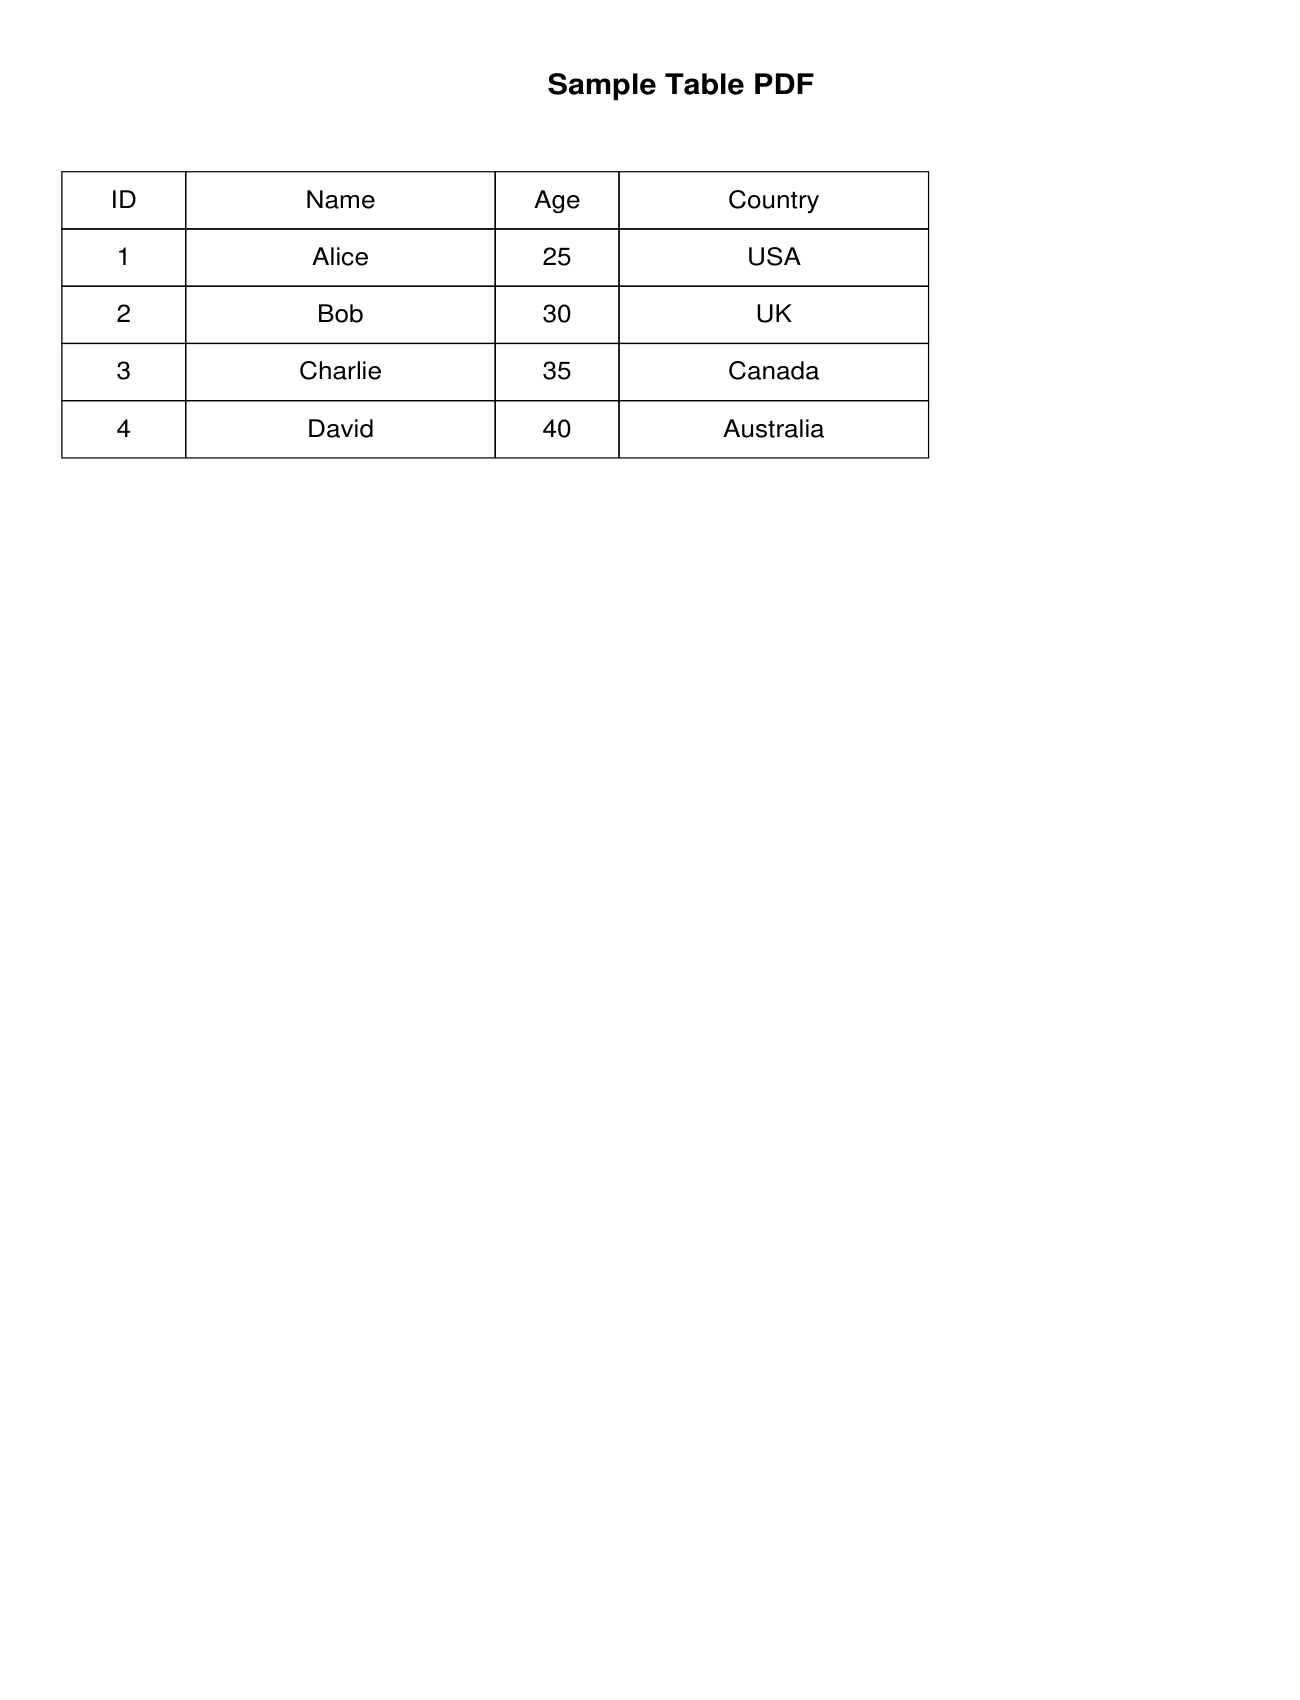

In [192]:
display(images[0])

In [193]:
with open('Sample_Table.json', 'r', encoding='utf-8') as f:
    data_tabel = json.load(f)

In [194]:
data_tabel

{'pages': [{'text': 'Sample Table PDF\nID\nName\nAge\nCountry\n1\nAlice\n25\nUSA\n2\nBob\n30\n30\nUK\n3\nCharlie\n35\nCanada\n4\nDavid\n40\nAustralia',
   'width': 2481,
   'height': 3508,
   'blocks': [{'bounding_box': [[1042, 153],
      [1550, 144],
      [1551, 195],
      [1043, 204]],
     'paragraphs': [{'bounding_box': [[1042, 153],
        [1550, 144],
        [1551, 195],
        [1043, 204]],
       'words': [{'text': 'Sample',
         'bounding_box': [[1042, 153], [1250, 149], [1251, 200], [1043, 204]]},
        {'text': 'Table',
         'bounding_box': [[1266, 150], [1416, 147], [1417, 197], [1267, 200]]},
        {'text': 'PDF',
         'bounding_box': [[1437, 146],
          [1550, 144],
          [1551, 195],
          [1438, 197]]}]}]},
    {'bounding_box': [[215, 394], [257, 395], [256, 428], [214, 427]],
     'paragraphs': [{'bounding_box': [[215, 394],
        [257, 395],
        [256, 428],
        [214, 427]],
       'words': [{'text': 'ID',
         'bounding_

In [48]:
def detect_tables_drow(image, detected_horizontal, detected_vertical):
    horizental_lines_yvalues=[]
    verticals_x2yvalues=[]
    table_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(table_image)
    
    # Combine horizontal and vertical lines to get a full grid of the table structure
    table_grid = cv2.add(detected_horizontal, detected_vertical)

    # Find all contours in the combined grid
    contours, _ = cv2.findContours(table_grid, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # Find all contours in the horizontal lines image
    contours_hor, _ = cv2.findContours(detected_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find all contours in the vertical lines image
    contours_vert, _ = cv2.findContours(detected_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the area of each contour
    areas = [cv2.contourArea(c) for c in contours]
    # Determine a threshold to filter out large contours that may represent boundaries
    if areas:
        mean_area = np.mean(areas)
        std_area = np.std(areas)
        contour_threshold = mean_area + 2 * std_area  # Adjust this factor based on specific use case

    # Exclude contours that are likely boundaries (much larger than the average)
    filtered_contours = [contours[i] for i in range(len(areas)) if areas[i] < contour_threshold]

    # Further refine to get contours of a minimum size to avoid noise and very small cells
    cell_contours = [cv2.boundingRect(c) for c in filtered_contours if cv2.contourArea(c) > 4000]
    print(len(cell_contours))
    if len(cell_contours)>1:
        table_exist= True
    else:
        table_exist= False
#         Draw a line for each contour detected
#     count=0
    for contour in contours_hor:
        # Calculate the bounding rectangle for each contour
        x, y, w, h = cv2.boundingRect(contour)
        if w>500:
#             count=count+1
            draw.line([(x, y + h // 2), (x + w, y + h // 2)], fill="red", width=5)
            horizental_lines_yvalues.append(y)
#             if count==4:
#                 break
#     count=0
    for contour in contours_vert:
        # Calculate the bounding rectangle for each contour
        x, y, w, h = cv2.boundingRect(contour)
        if h > 200 and x>2:  # Adjust height requirement as needed
            midpoint_x = x + w // 2
            # Draw a vertical line across the height of the contour
            draw.line([(midpoint_x, (y+20)), (midpoint_x, y + (h-20))], fill="red", width=5)
            # Append the line data to the list as a dictionary
            verticals_x2yvalues.append({midpoint_x: ((y+20), y + (h-20))})
#             if count==4:
#                 break
    return table_image,table_exist,horizental_lines_yvalues,verticals_x2yvalues  

In [49]:
# Detect tables within the image
def detect_tables(detected_horizontal, detected_vertical):
    horizental_lines_yvalues=[]
    verticals_x2yvalues=[]
    # Combine horizontal and vertical lines to get a full grid of the table structure
    table_grid = cv2.add(detected_horizontal, detected_vertical)
    # Find all contours in the combined grid
    contours, _ = cv2.findContours(table_grid, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # Find all contours in the horizontal lines image
    contours_hor, _ = cv2.findContours(detected_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find all contours in the vertical lines image
    contours_vert, _ = cv2.findContours(detected_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Calculate the area of each contour
    areas = [cv2.contourArea(c) for c in contours]
    # Determine a threshold to filter out large contours that may represent boundaries
    if areas:
        mean_area = np.mean(areas)
        std_area = np.std(areas)
        contour_threshold = mean_area + 2 * std_area  # Adjust this factor based on specific use case
    # Exclude contours that are likely boundaries (much larger than the average)
    filtered_contours = [contours[i] for i in range(len(areas)) if areas[i] < contour_threshold]
    # Further refine to get contours of a minimum size to avoid noise and very small cells
    cell_contours = [cv2.boundingRect(c) for c in filtered_contours if cv2.contourArea(c) > 4000]
    if len(cell_contours)>5:
        table_exist= True
    else:
        table_exist= False
    for contour in contours_hor:
        # Calculate the bounding rectangle for each contour
        x, y, w, h = cv2.boundingRect(contour)
        if w>500:
            horizental_lines_yvalues.append(y)
    for contour in contours_vert:
        # Calculate the bounding rectangle for each contour
        x, y, w, h = cv2.boundingRect(contour)
        if h > 200 and x>2:  # Adjust height requirement as needed
            midpoint_x = x + w // 2
            verticals_x2yvalues.append({midpoint_x: ((y+20), y + (h-20))})
    return table_exist,horizental_lines_yvalues,verticals_x2yvalues

In [50]:
open_cv_image = np.array(images[0])
open_cv_image = open_cv_image[:, :, ::-1].copy()  # Convert RGB to BGR

# Convert to grayscale
gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Detect horizontal and vertical lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
horizontal_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
detected_horizontal = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=2)

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
vertical_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
detected_vertical = cv2.dilate(vertical_lines, vertical_kernel, iterations=2)

In [51]:
page_width = data_tabel['pages'][0].get("width", 1)
page_height = data_tabel['pages'][0].get("height", 1)
image_width, image_height = images[0].size

words_with_coordinates=normalize_words_with_coordinates(data_tabel, page_width, page_height, image_width, image_height,page_num=0)

In [52]:
words_with_coordinates[0]

{'Sample': [(545, 74), (654, 72), (655, 96), (546, 98)]}

In [53]:
table_exist,horizental_lines_yvalues,verticals_x2yvalues=detect_tables(detected_horizontal, detected_vertical)

In [54]:
table_exist

True

In [55]:
table_image,table_exist,horizental_lines_yvalues,verticals_x2yvalues=detect_tables_drow(open_cv_image,detected_horizontal, detected_vertical)

20


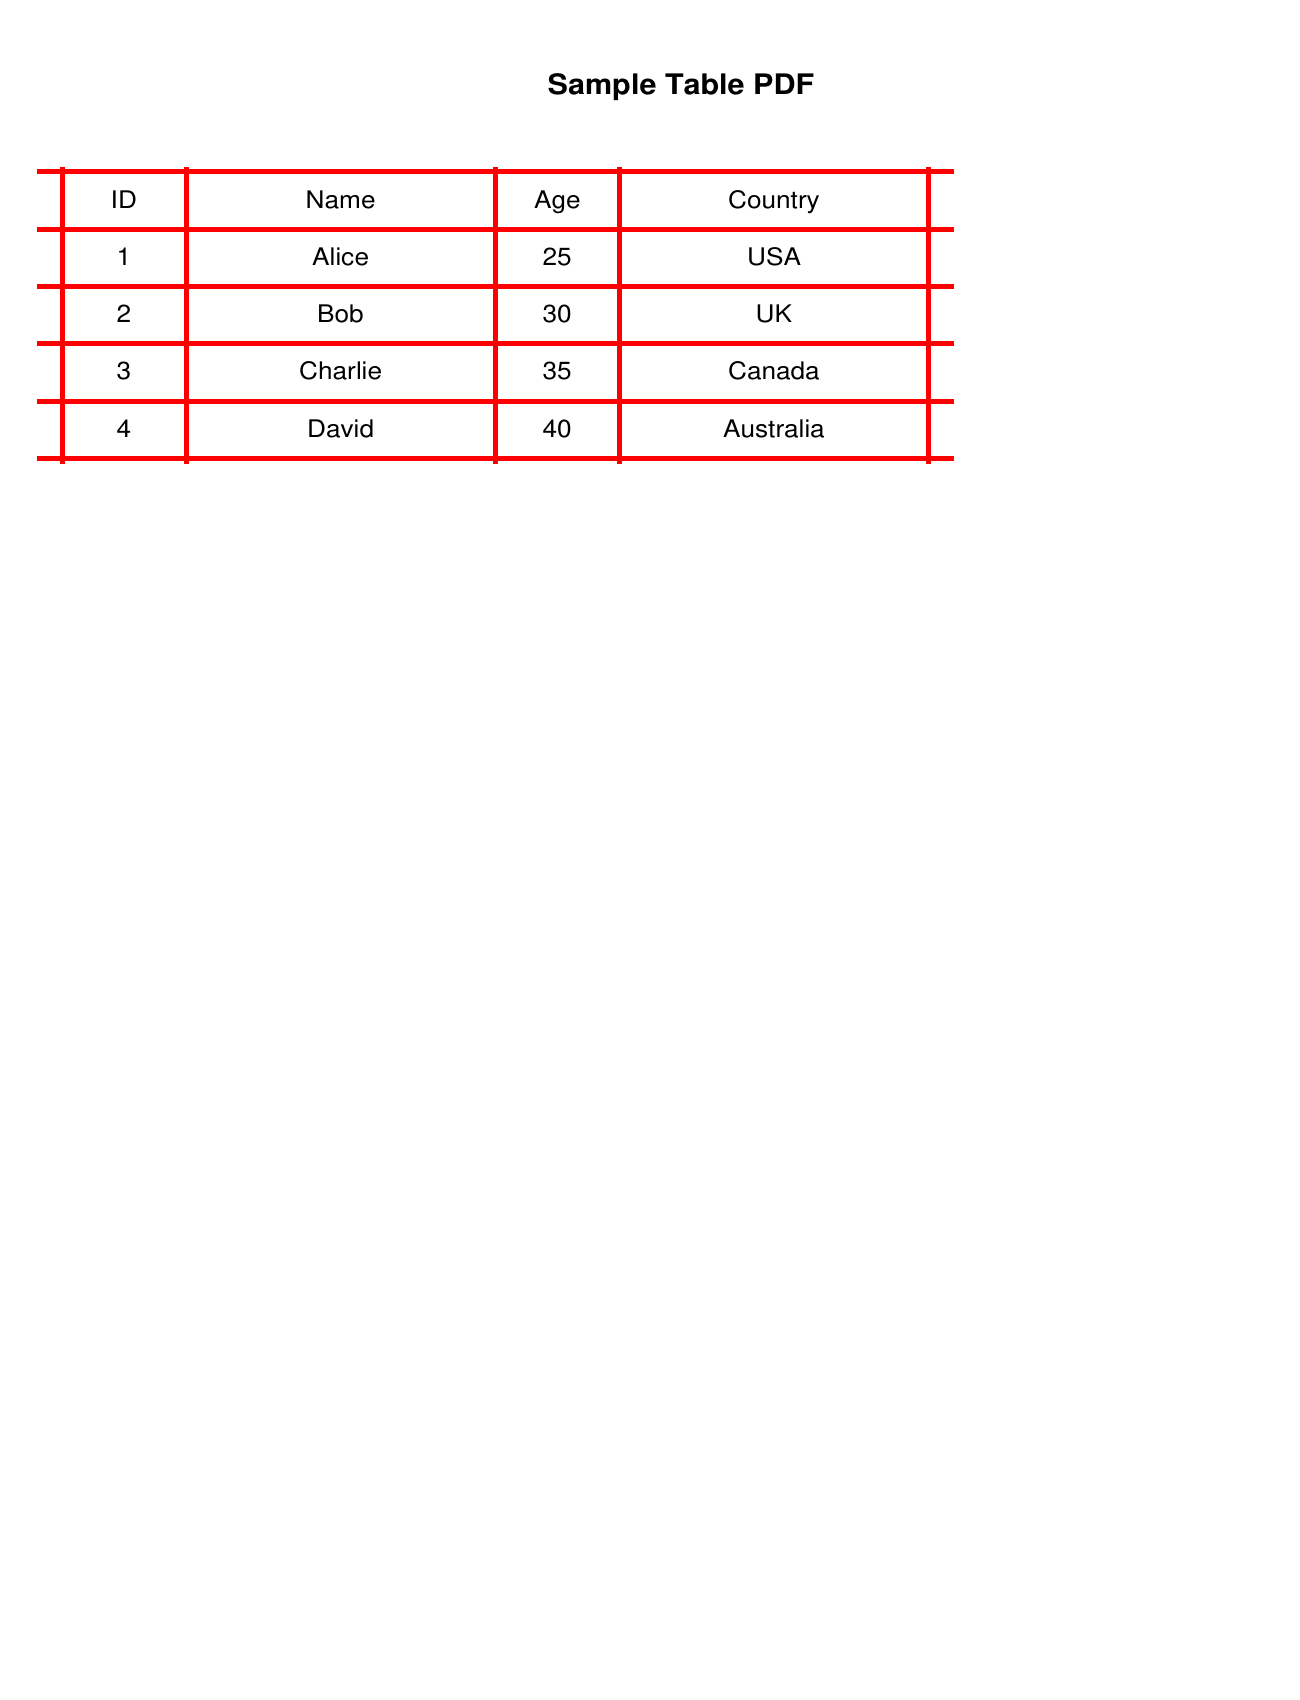

In [56]:
display(table_image)

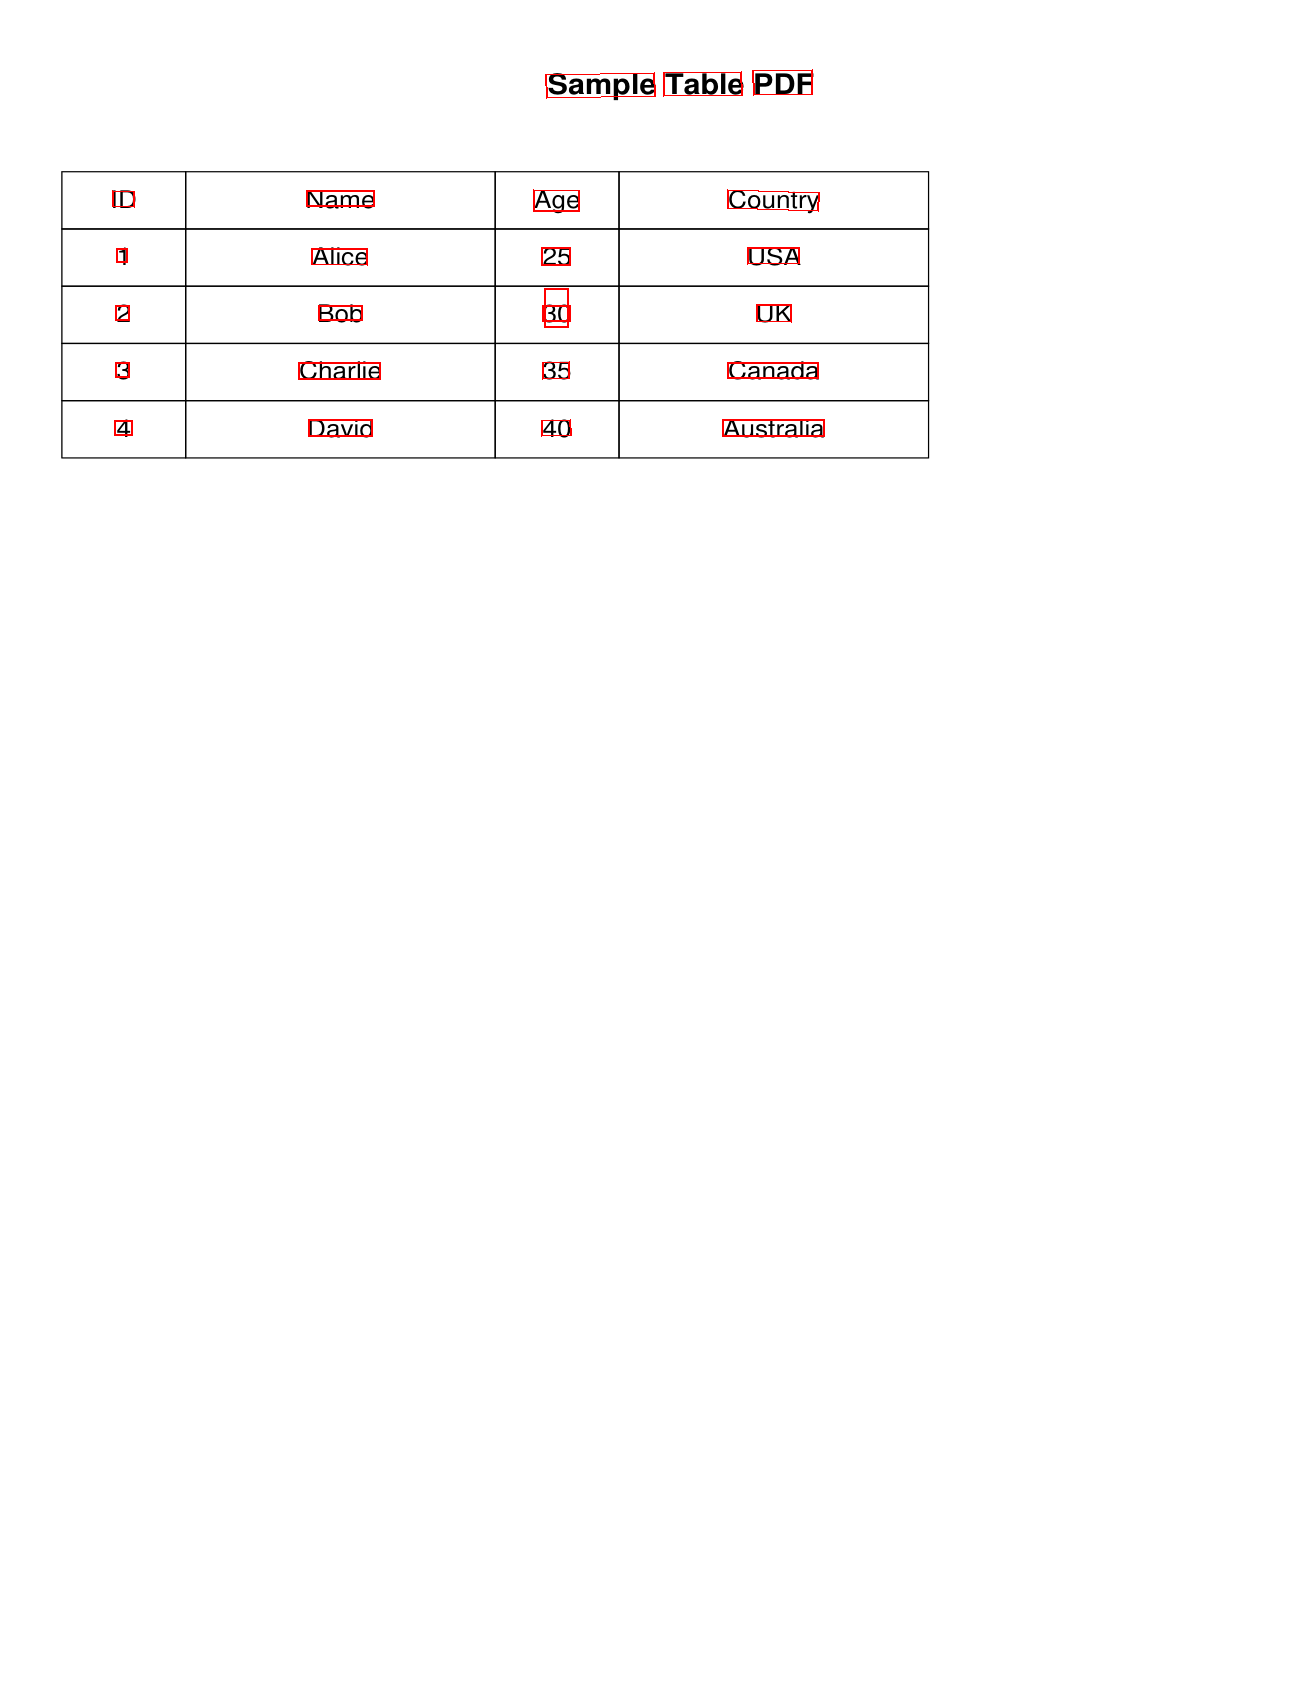

In [57]:
normalized_boxes=process_page_and_draw_boxes(data_tabel['pages'][0], images[0])
    # Draw the normalized bounding boxes on the image
draw_boxes(images[0], normalized_boxes)

In [58]:
output_text_pages=[]

In [59]:
def process_table_rows(horizental_lines_yvalues, words_with_coordinates, verticals_x2yvalues, output_text_pages, language):
    """
    Process table rows and adjust their direction based on the provided language.

    Args:
        horizental_lines_yvalues (list): Y-values of horizontal lines in the table.
        words_with_coordinates (list): List of words with their bounding box coordinates.
        verticals_x2yvalues (list): Vertical lines defining column split points.
        output_text_pages (list): List to store the formatted text pages.
        language (str): Language of the text ('ar' for Arabic, 'en' for English, etc.).

    Returns:
        None
    """
    h_lines_y = sorted(horizental_lines_yvalues, reverse=False)  # Sort ascending
    for i in range(len(h_lines_y) - 1):
        row_top = h_lines_y[i]
        row_bottom = h_lines_y[i + 1]
        row_words = [
            word_dict
            for word_dict in words_with_coordinates
            for word, coords in word_dict.items()
            if row_top <= (coords[0][1] + coords[3][1]) / 2 < row_bottom
        ]

        # Check if columns are defined for the current row
        split_points = [
            x
            for col_def in verticals_x2yvalues
            for x, (y0, y1) in col_def.items()
            if y0 < row_top and y1 + 50 >= row_bottom
        ]
        if not row_words:  # If no words in the row, continue to next row
            continue

        if not split_points:  # If no columns, handle words as a single block
            relevant_cols = [
                min(
                    [
                        coord
                        for word_dict in row_words
                        for word, coords in word_dict.items()
                        for coord in (coords[0][0], coords[1][0])
                    ]
                )
            ]
        else:
            relevant_cols = sorted(split_points)

        words_lists = separate_words(relevant_cols, row_words)
        row_output = []

        try:
            # Reverse or keep the order based on the provided language
            if language == "eng":
                words_lists = words_lists  # Keep as is for Arabic
            else:
                words_lists = words_lists[::-1]  # Reverse for English or other languages

            for j in range(len(words_lists)):
                data = words_lists[j]
                # Organize words by y-location
                words_by_line = {}
                for item in data:
                    word, coordinates = list(item.items())[0]
                    y_values = [point[1] for point in coordinates]
                    line = round(sum(y_values) / len(y_values))

                    # Check if the word is on an existing line (within the tolerance)
                    for existing_line in words_by_line:
                        if abs(existing_line - line) <= tolerance:
                            line = existing_line
                            break

                    if line not in words_by_line:
                        words_by_line[line] = []
                    words_by_line[line].append(word)

                # Concatenate all lines into one
                all_words = []
                for line in words_by_line:
                    all_words.extend(words_by_line[line])
                row_output.append(" ".join(all_words))

            # Assemble the output for the row and add it to output_text_pages
            formatted_row = " ‖ ".join(row_output) + "\n"  # Add a newline after the row
            output_text_pages.append(formatted_row)
            output_text_pages.append("-" * 25 + "\n")  # Add a horizontal line separator

        except Exception as e:
            print(e)
            continue


In [60]:
output_text_pages = []
process_table_rows(
    horizental_lines_yvalues=horizental_lines_yvalues,
    words_with_coordinates=words_with_coordinates,
    verticals_x2yvalues=verticals_x2yvalues,
    output_text_pages=output_text_pages,
    language="eng"  # Pass "ar" for Arabic or "en" for English
)

In [61]:
output_text_pages

[' ‖ ID ‖ Name ‖ Age ‖ Country\n',
 '-------------------------\n',
 ' ‖ 1 ‖ Alice ‖ 25 ‖ USA\n',
 '-------------------------\n',
 ' ‖ 2 ‖ Bob ‖ 30 30 ‖ UK\n',
 '-------------------------\n',
 ' ‖ 3 ‖ Charlie ‖ 35 ‖ Canada\n',
 '-------------------------\n',
 ' ‖ 4 ‖ David ‖ 40 ‖ Australia\n',
 '-------------------------\n']